In [2]:
import os
from pathlib import Path
from mistralai import Mistral
from IPython.core.display import display, Markdown

/tmp/ipykernel_3929/4220353073.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Markdown


In [ ]:
#api_key = userdata.get('Mistral_OCR')
client = Mistral(api_key="")
     

In [10]:
pdf_path="/workspaces/AgenticAI-Systems/RAG/Document/مراسلات.pdf"
uploaded_pdf = client.files.upload(
    file={
        "file_name": pdf_path,
        "content": open(pdf_path, "rb"),
    },
    purpose="ocr"
)

In [11]:
client.files.retrieve(file_id=uploaded_pdf.id)


RetrieveFileOut(id='937df365-08d7-4edb-95ad-d4fd14ccd0e4', object='file', size_bytes=4867782, created_at=1742409617, filename='مراسلات.pdf', purpose='ocr', sample_type='ocr_input', source='upload', deleted=False, num_lines=None)

In [12]:
signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)


In [13]:
ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": signed_url.url,
    },
    include_image_base64=True
)

[OCRPageObject(index=0, markdown='Kuwait Gulf Oil Company (K.G.C)\nA Subsidiary of Kuwait Petroleum Corporation\nA Subsidiary of Kuwait Petroleum Corporation\nA Subsidiary of Kuwait Petroleum Corporation\nالمصطفى\n\n| Date : | التاريخ : 19 سبتمبر 2017 |\n| :--: | :--: |\n| From : |  |\n| To : | رئيس فريق عمل المـدفـوعـات الماليـمـا |\n| Ref. : | رئيس فريق عمل الشؤون القانونيـمـا للمكـتب الرئيسي والتقاضي |\n\nالموضوع : الدعوى رقم 2017/1876 عمالـى كلى / 2\nالمقامـ من سالم عبداللّ محمد سالم اليش ر 86577 (ضـد الشـر كحـمـا\nبالإشـارة الى مـذكـرتكـم مرجع رقـم 2017/330/17 المؤرخـّ في 22 أغسطس 2017 بخصوص\nالموضـوع المذكور أعلاه، نـرفق لكـم نسـخـ مـن التسـويـم النهائيـم لـستحقات نهايـم الخدمـم والمخالصـمـا\nالنهايـم مـهورة بتوقيع المدعي.\n\nوتفضلــوا بقبــول فائـق الاحـــترام : . .\n![img-0.jpeg](img-0.jpeg)\n\n19 SEP 2017\nTel: 14 9 9\nFax: 14 9 9\n10. 9\n\n| Kuwait Gulf Oil Company <br> Team Leader HO (LA \\& Lifigation) |  |  |  |\n| :--: | :--: | :--: | :--: |\n|  | Action | FV | Discuss |\
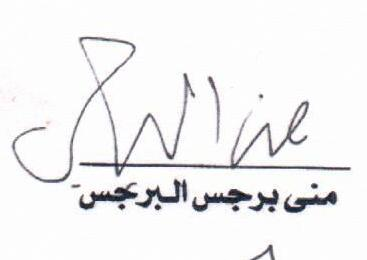
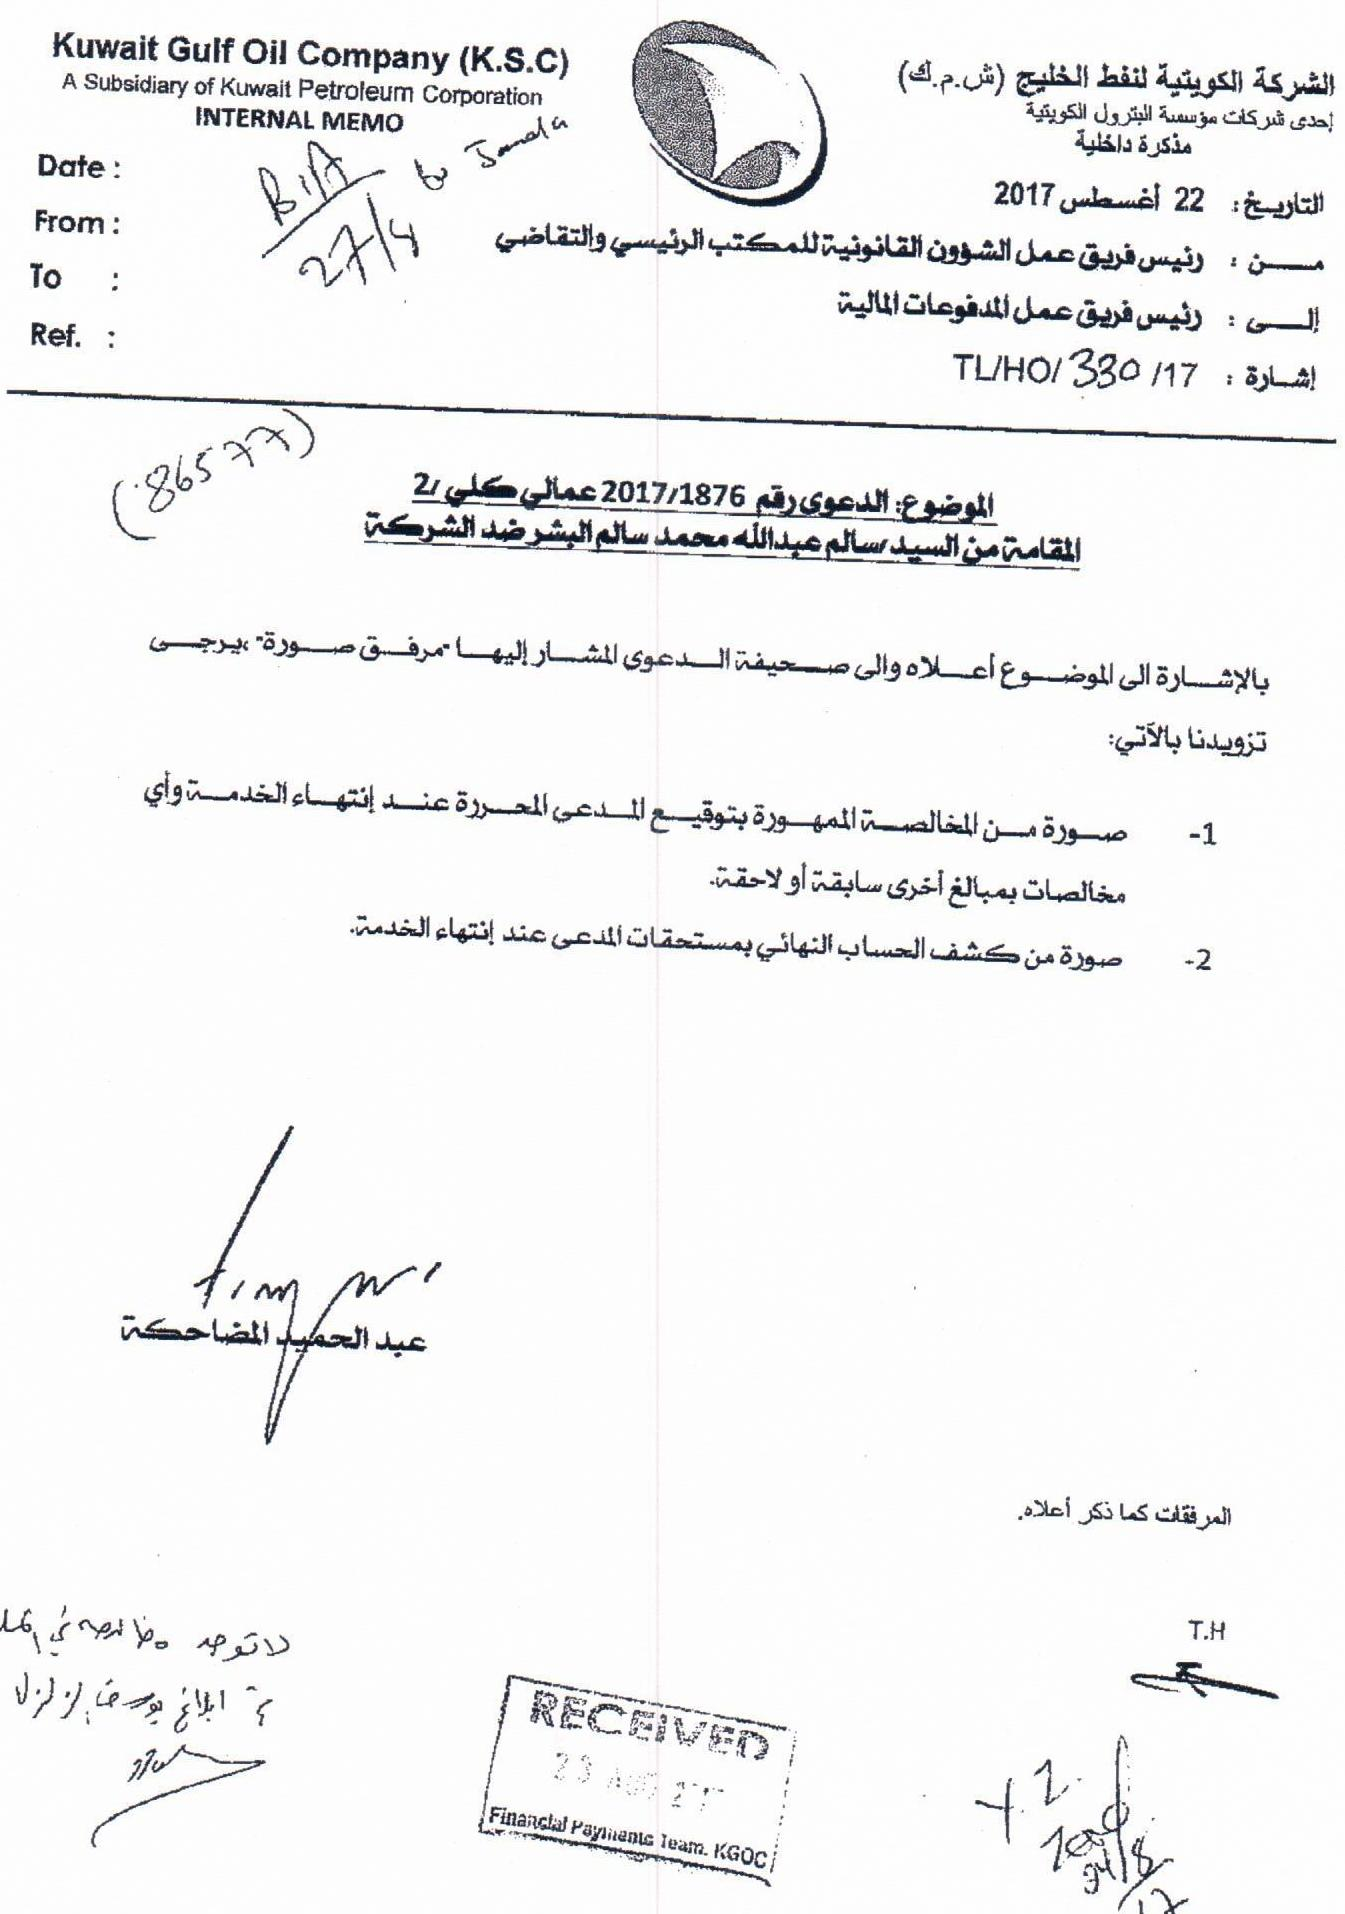
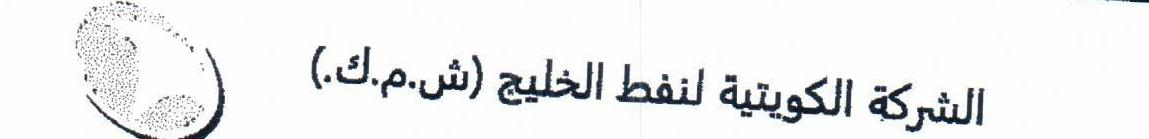
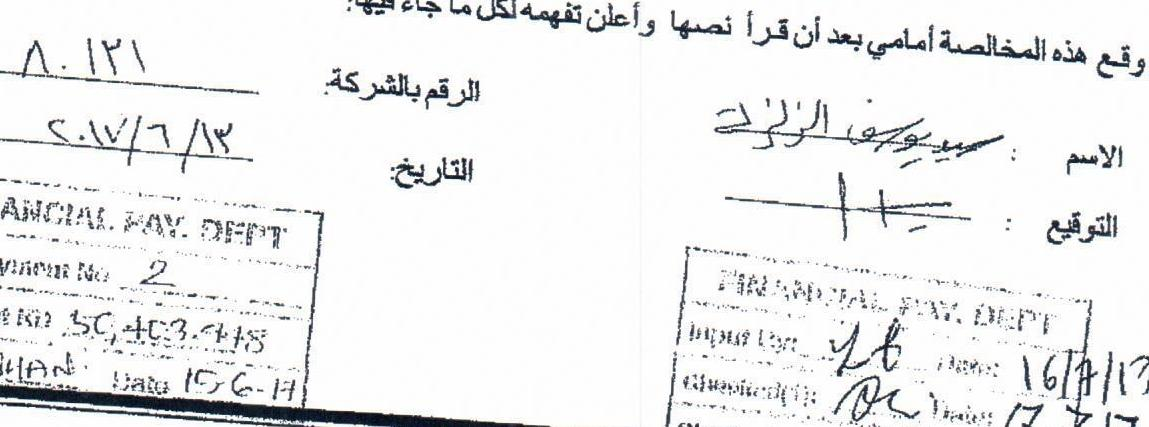
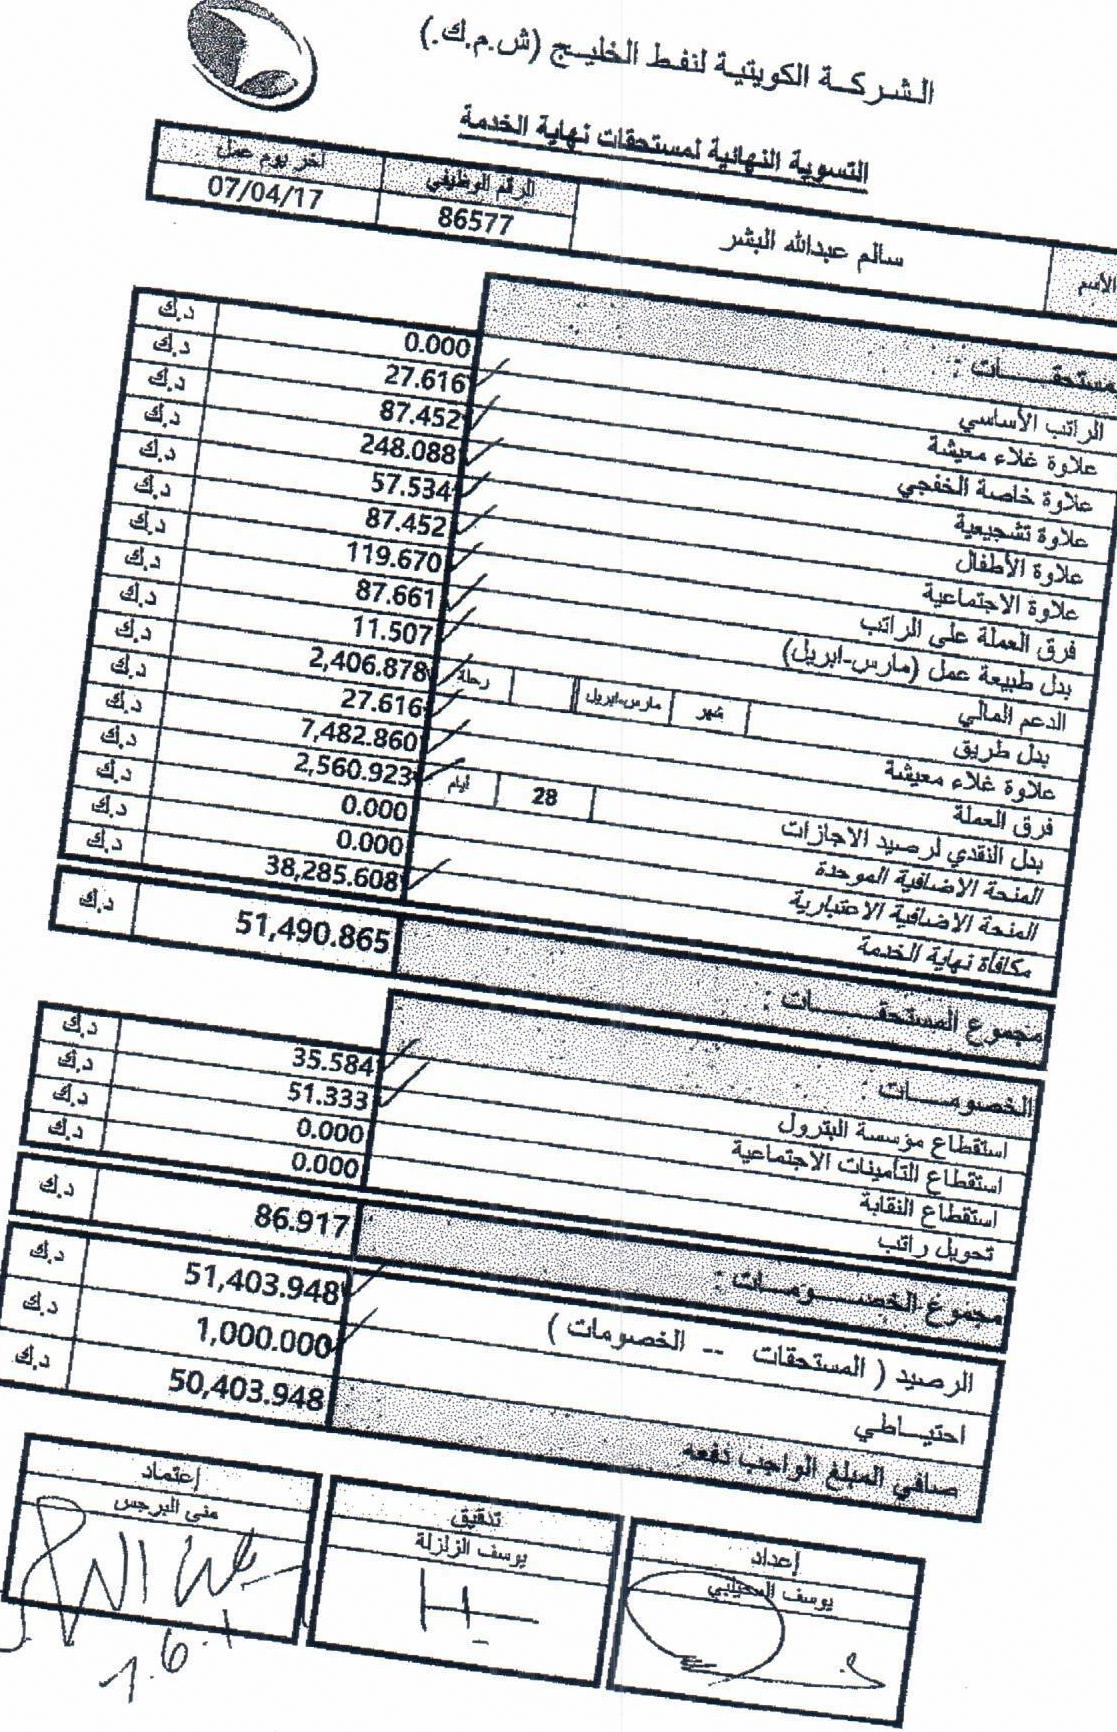
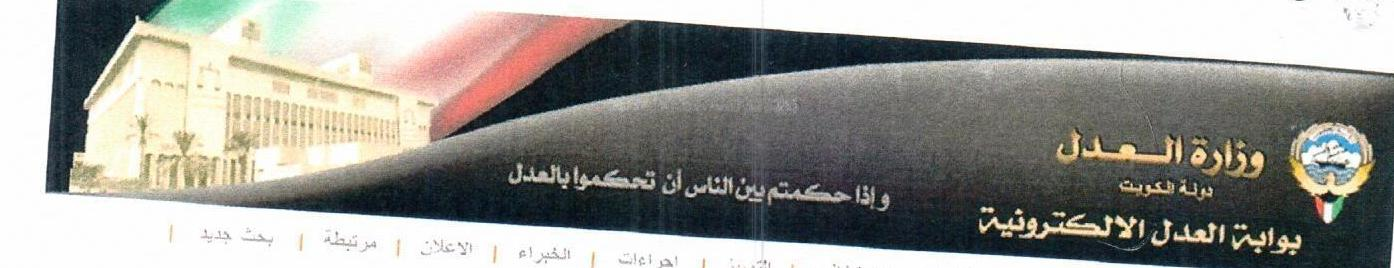
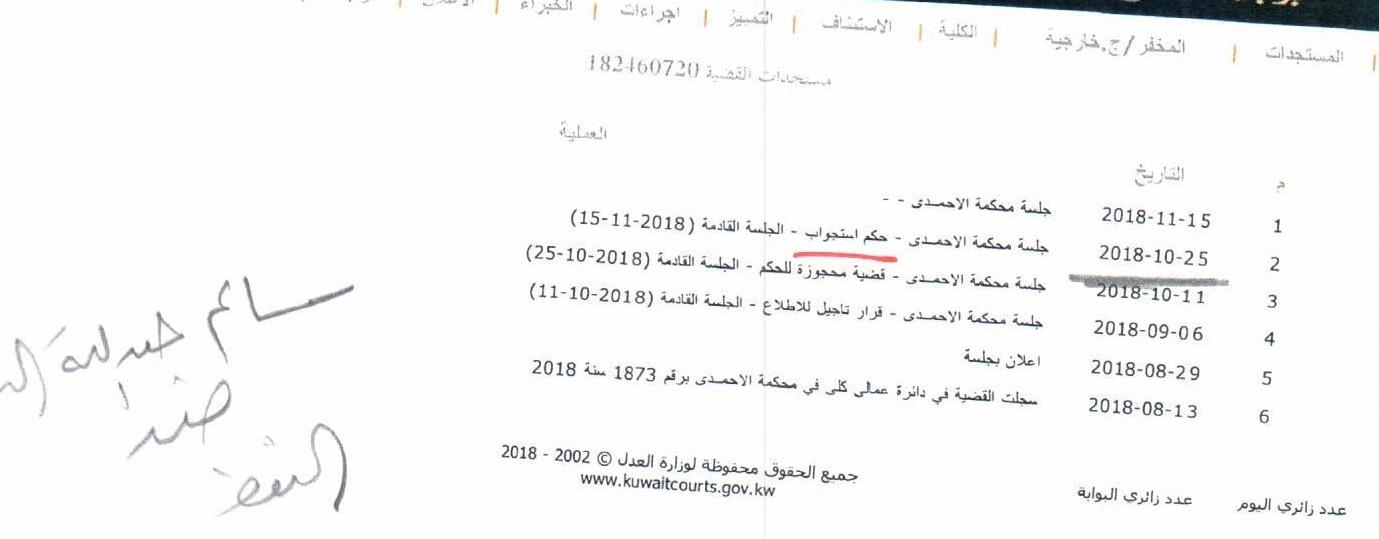
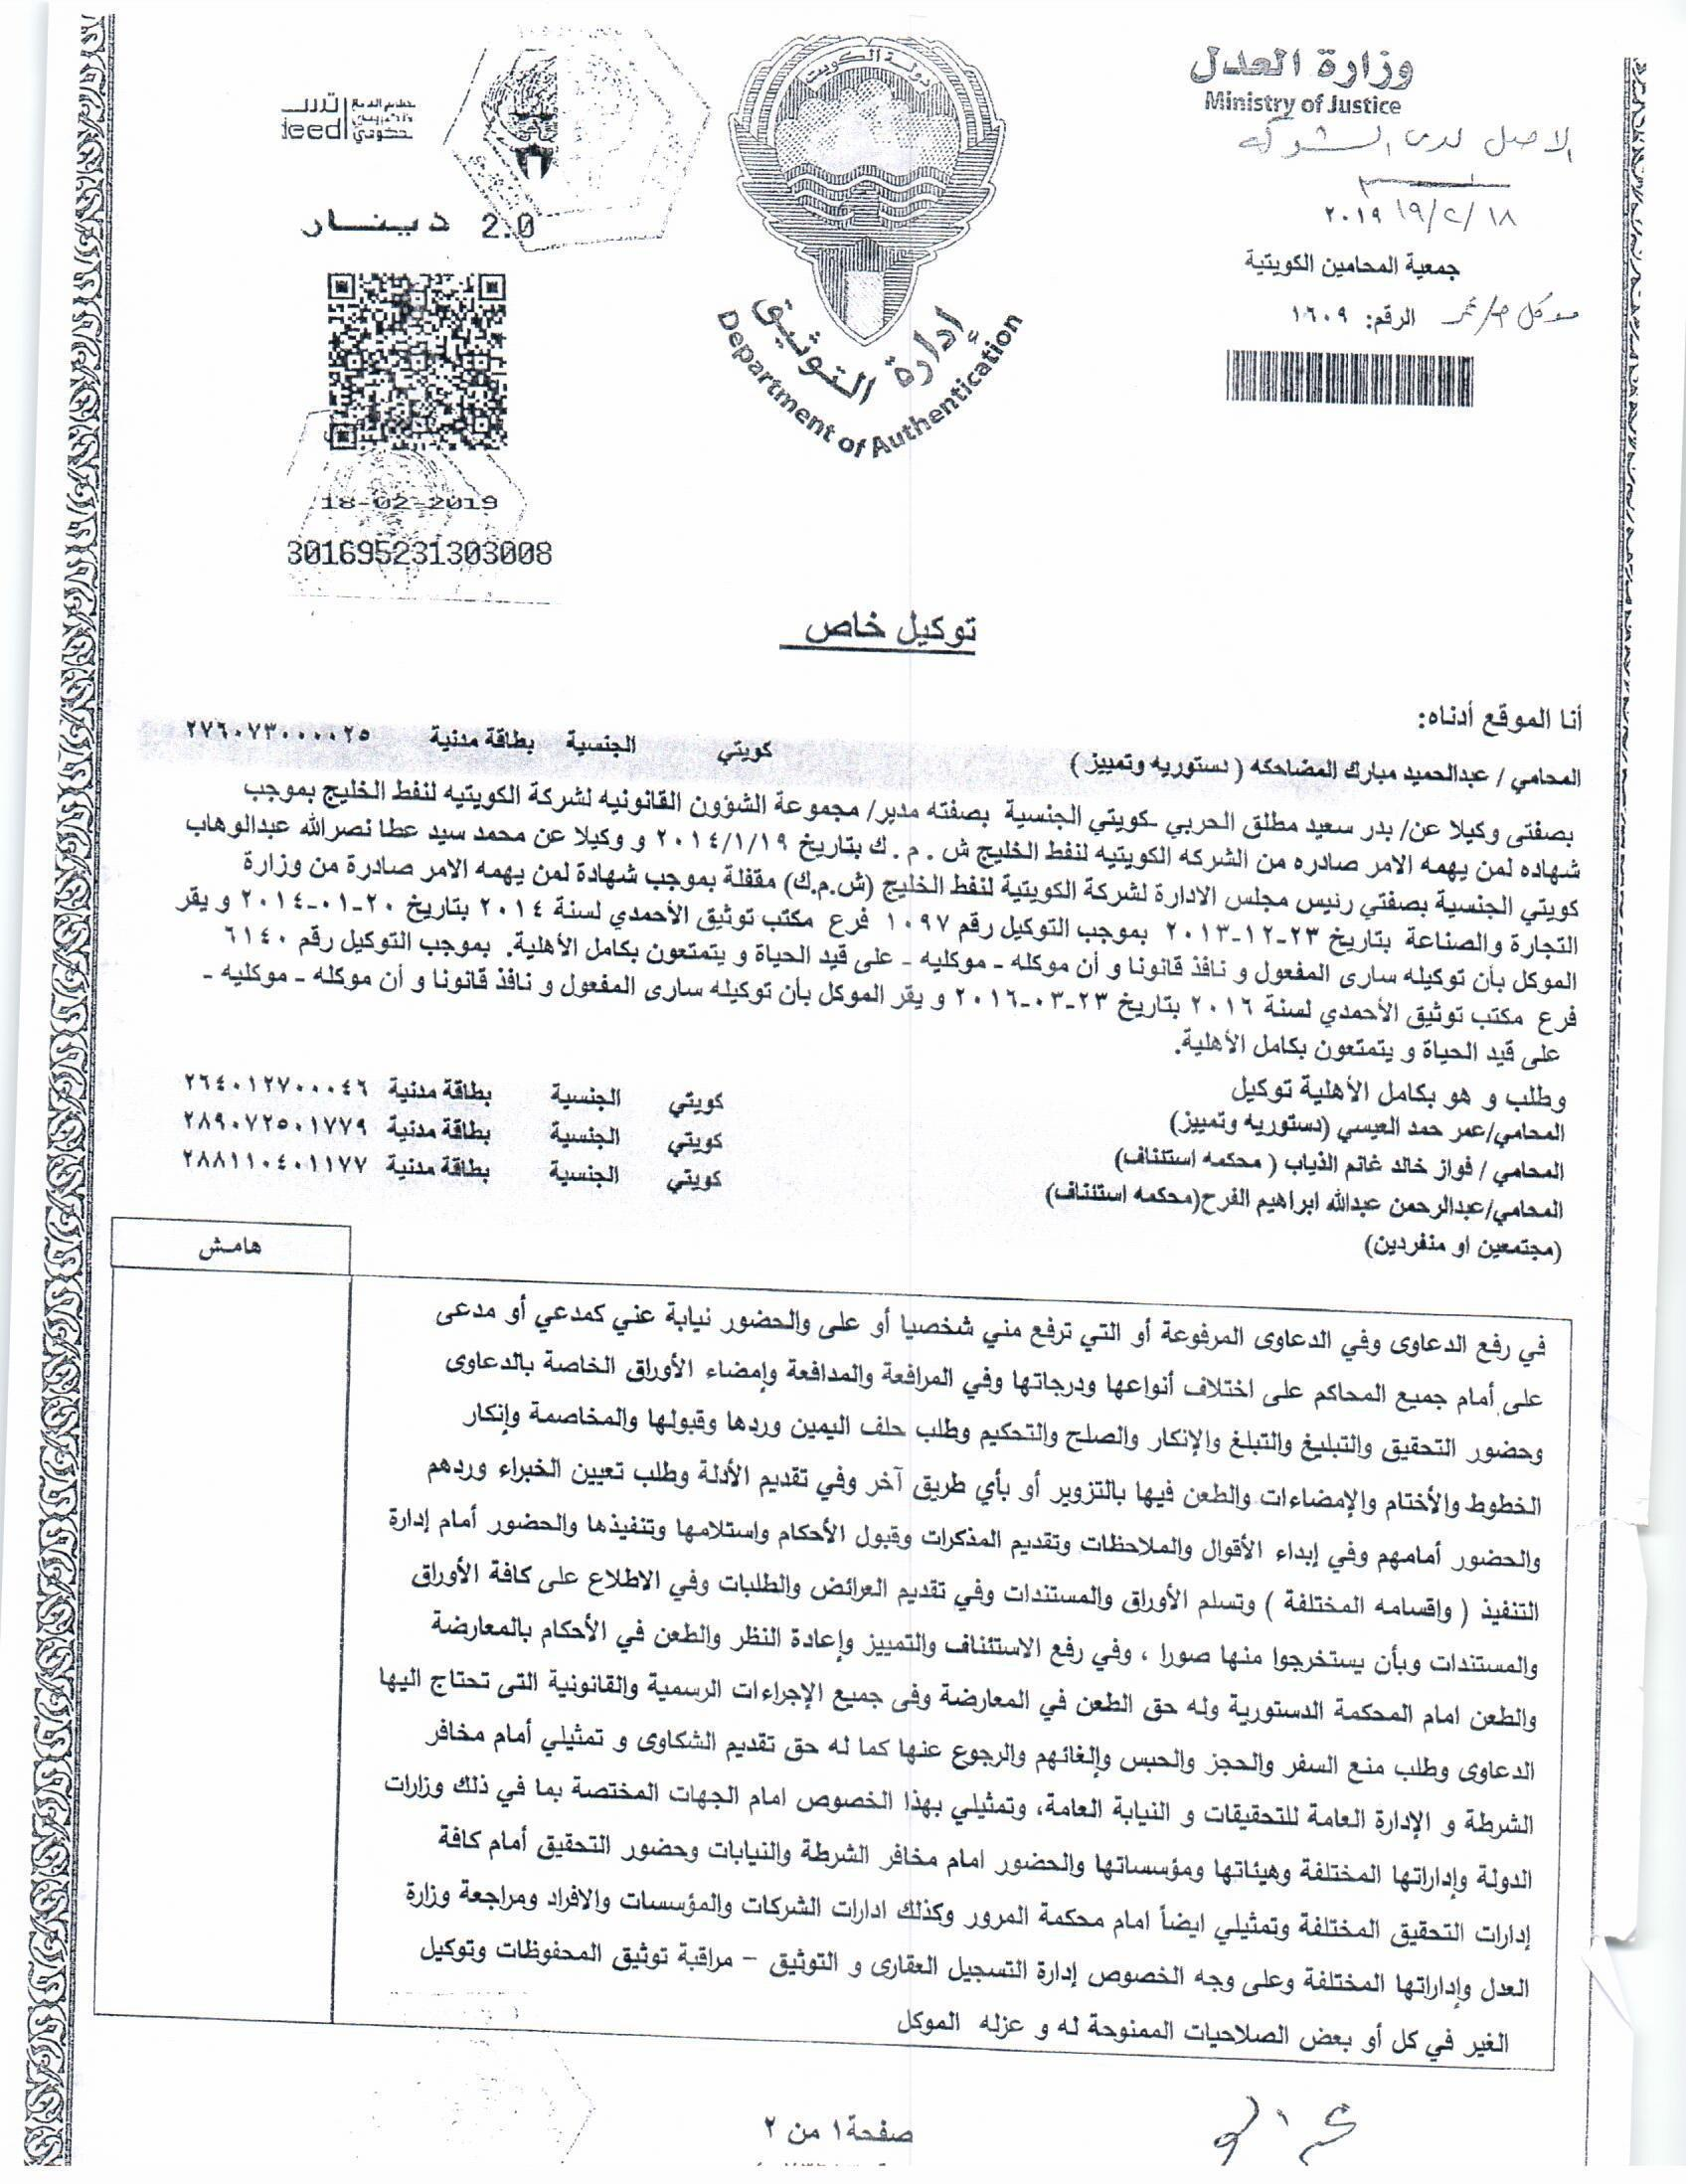
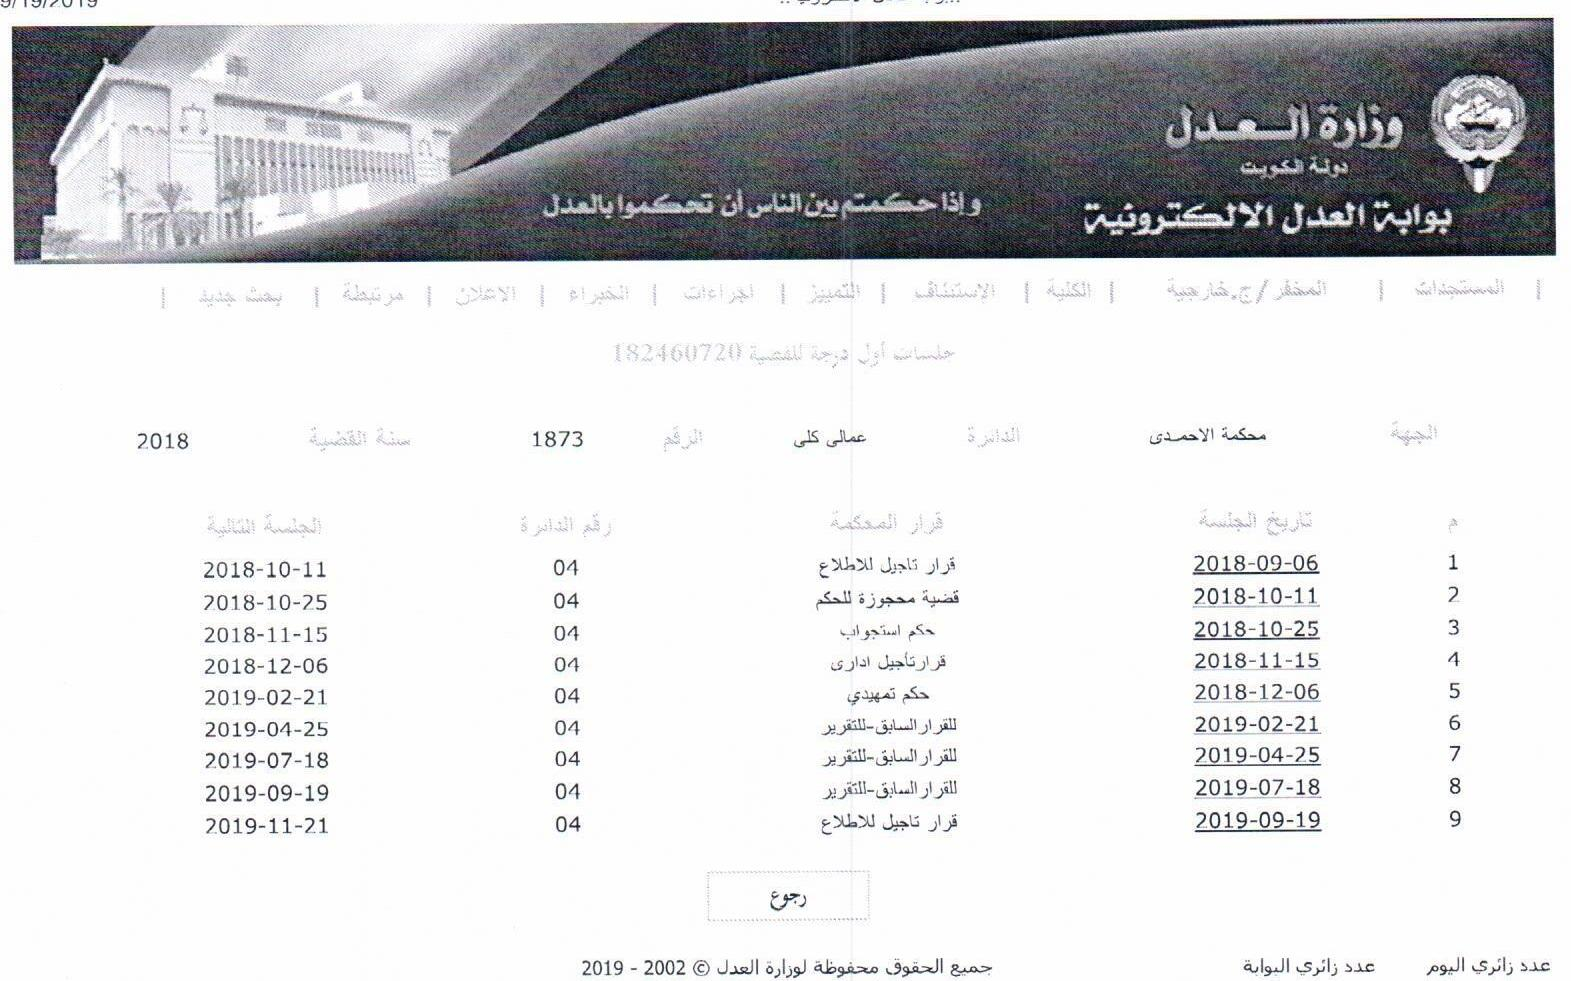
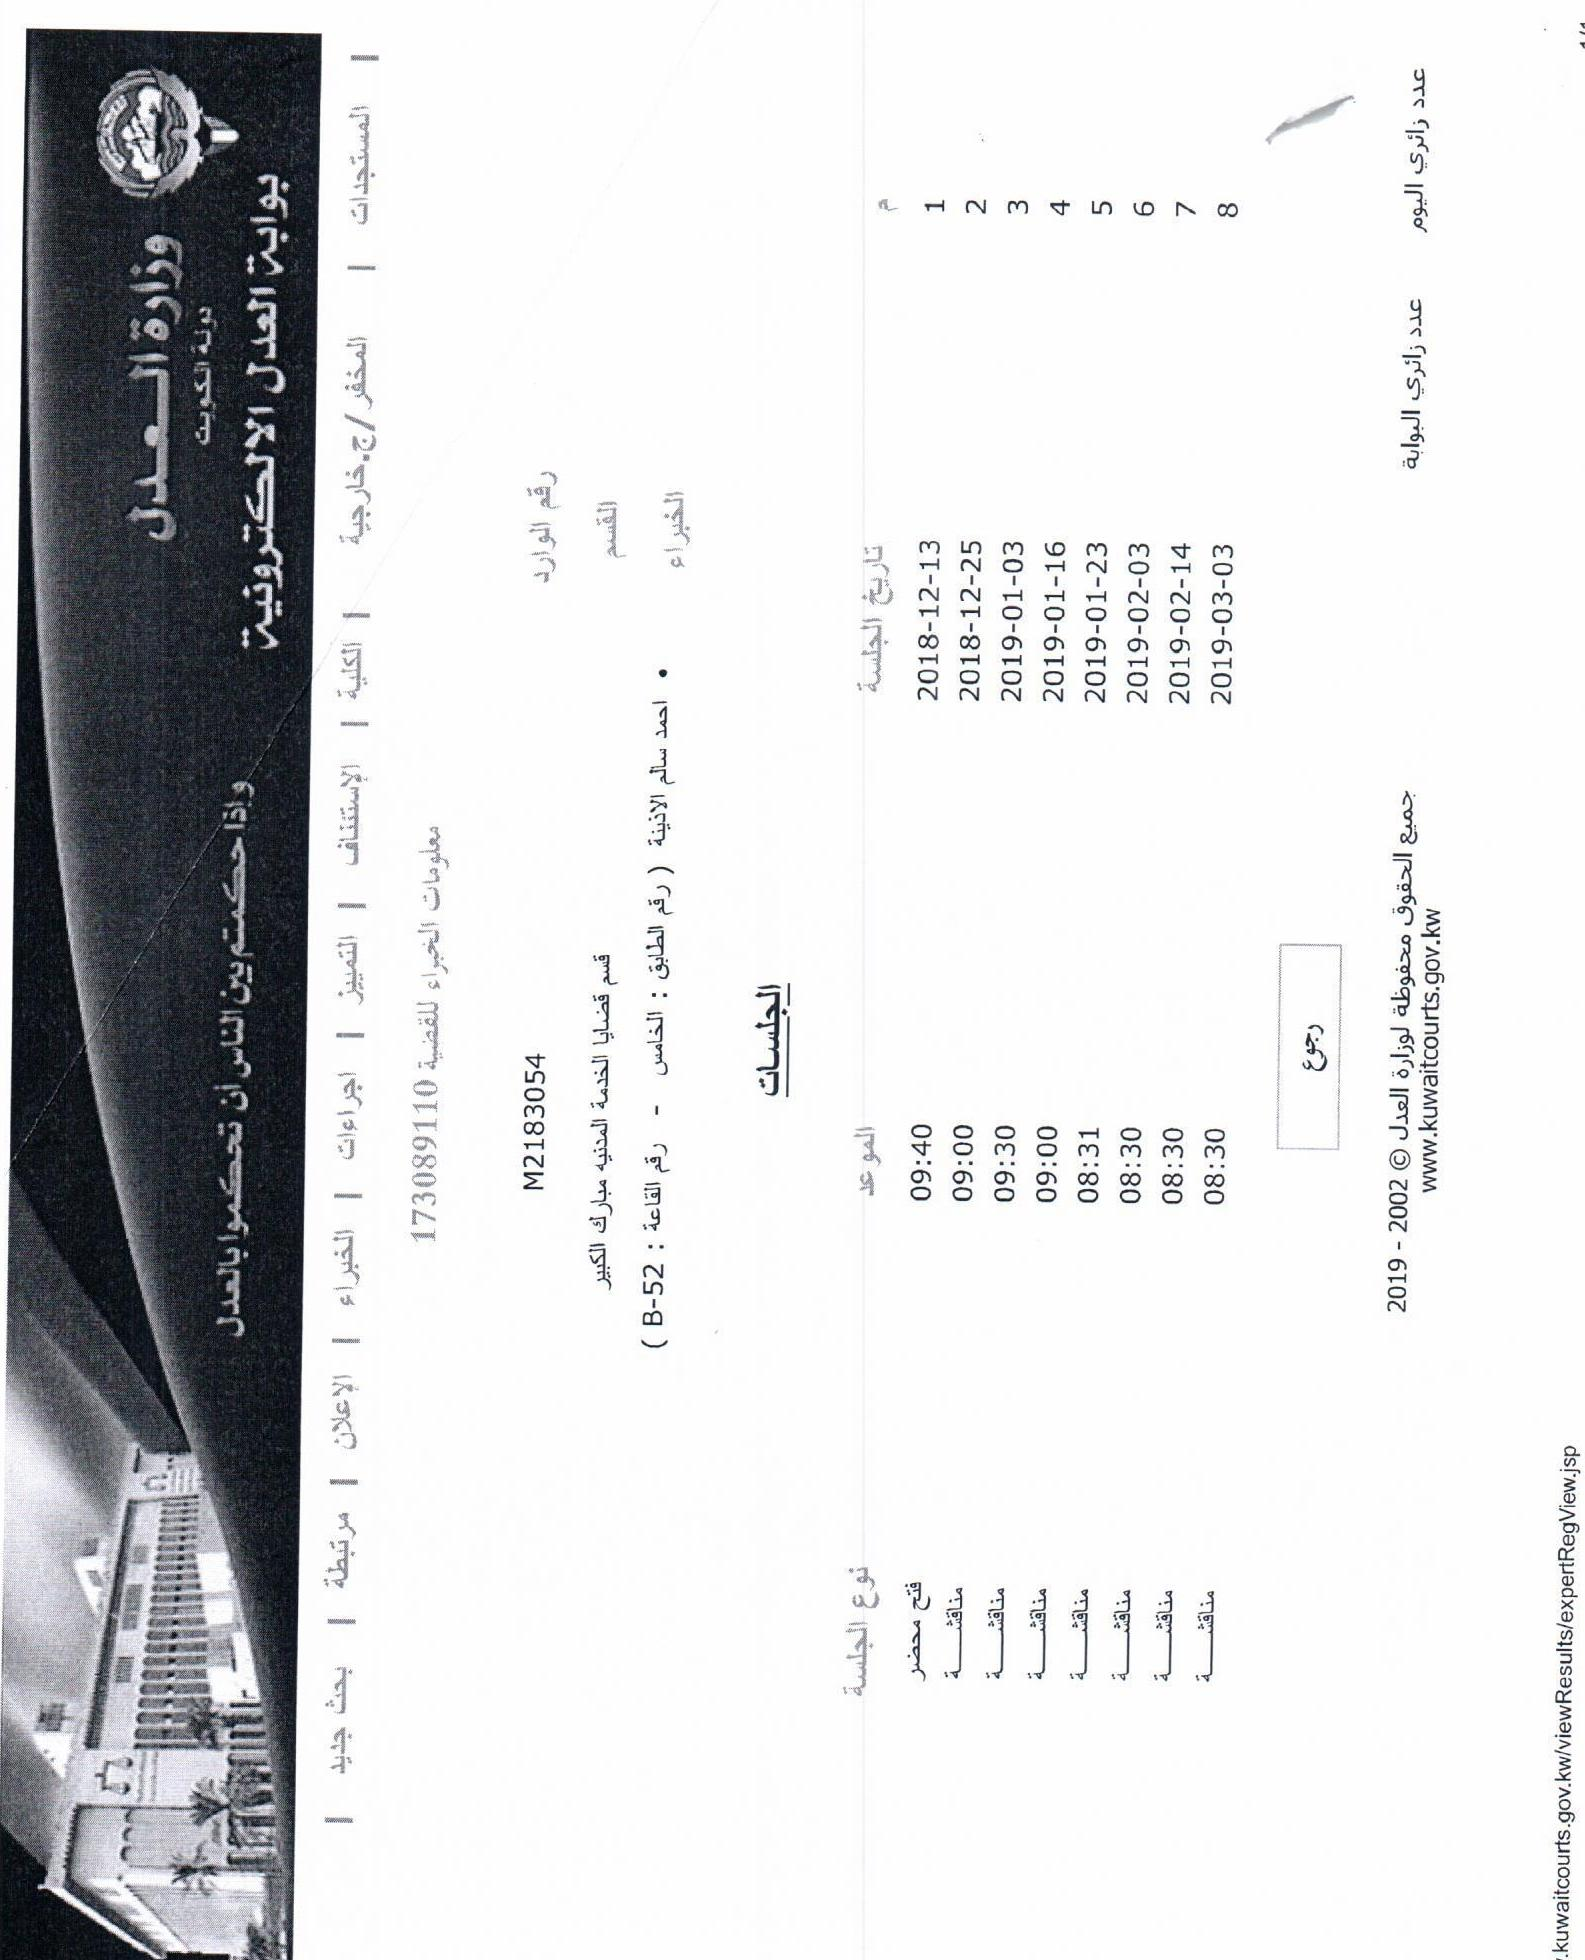
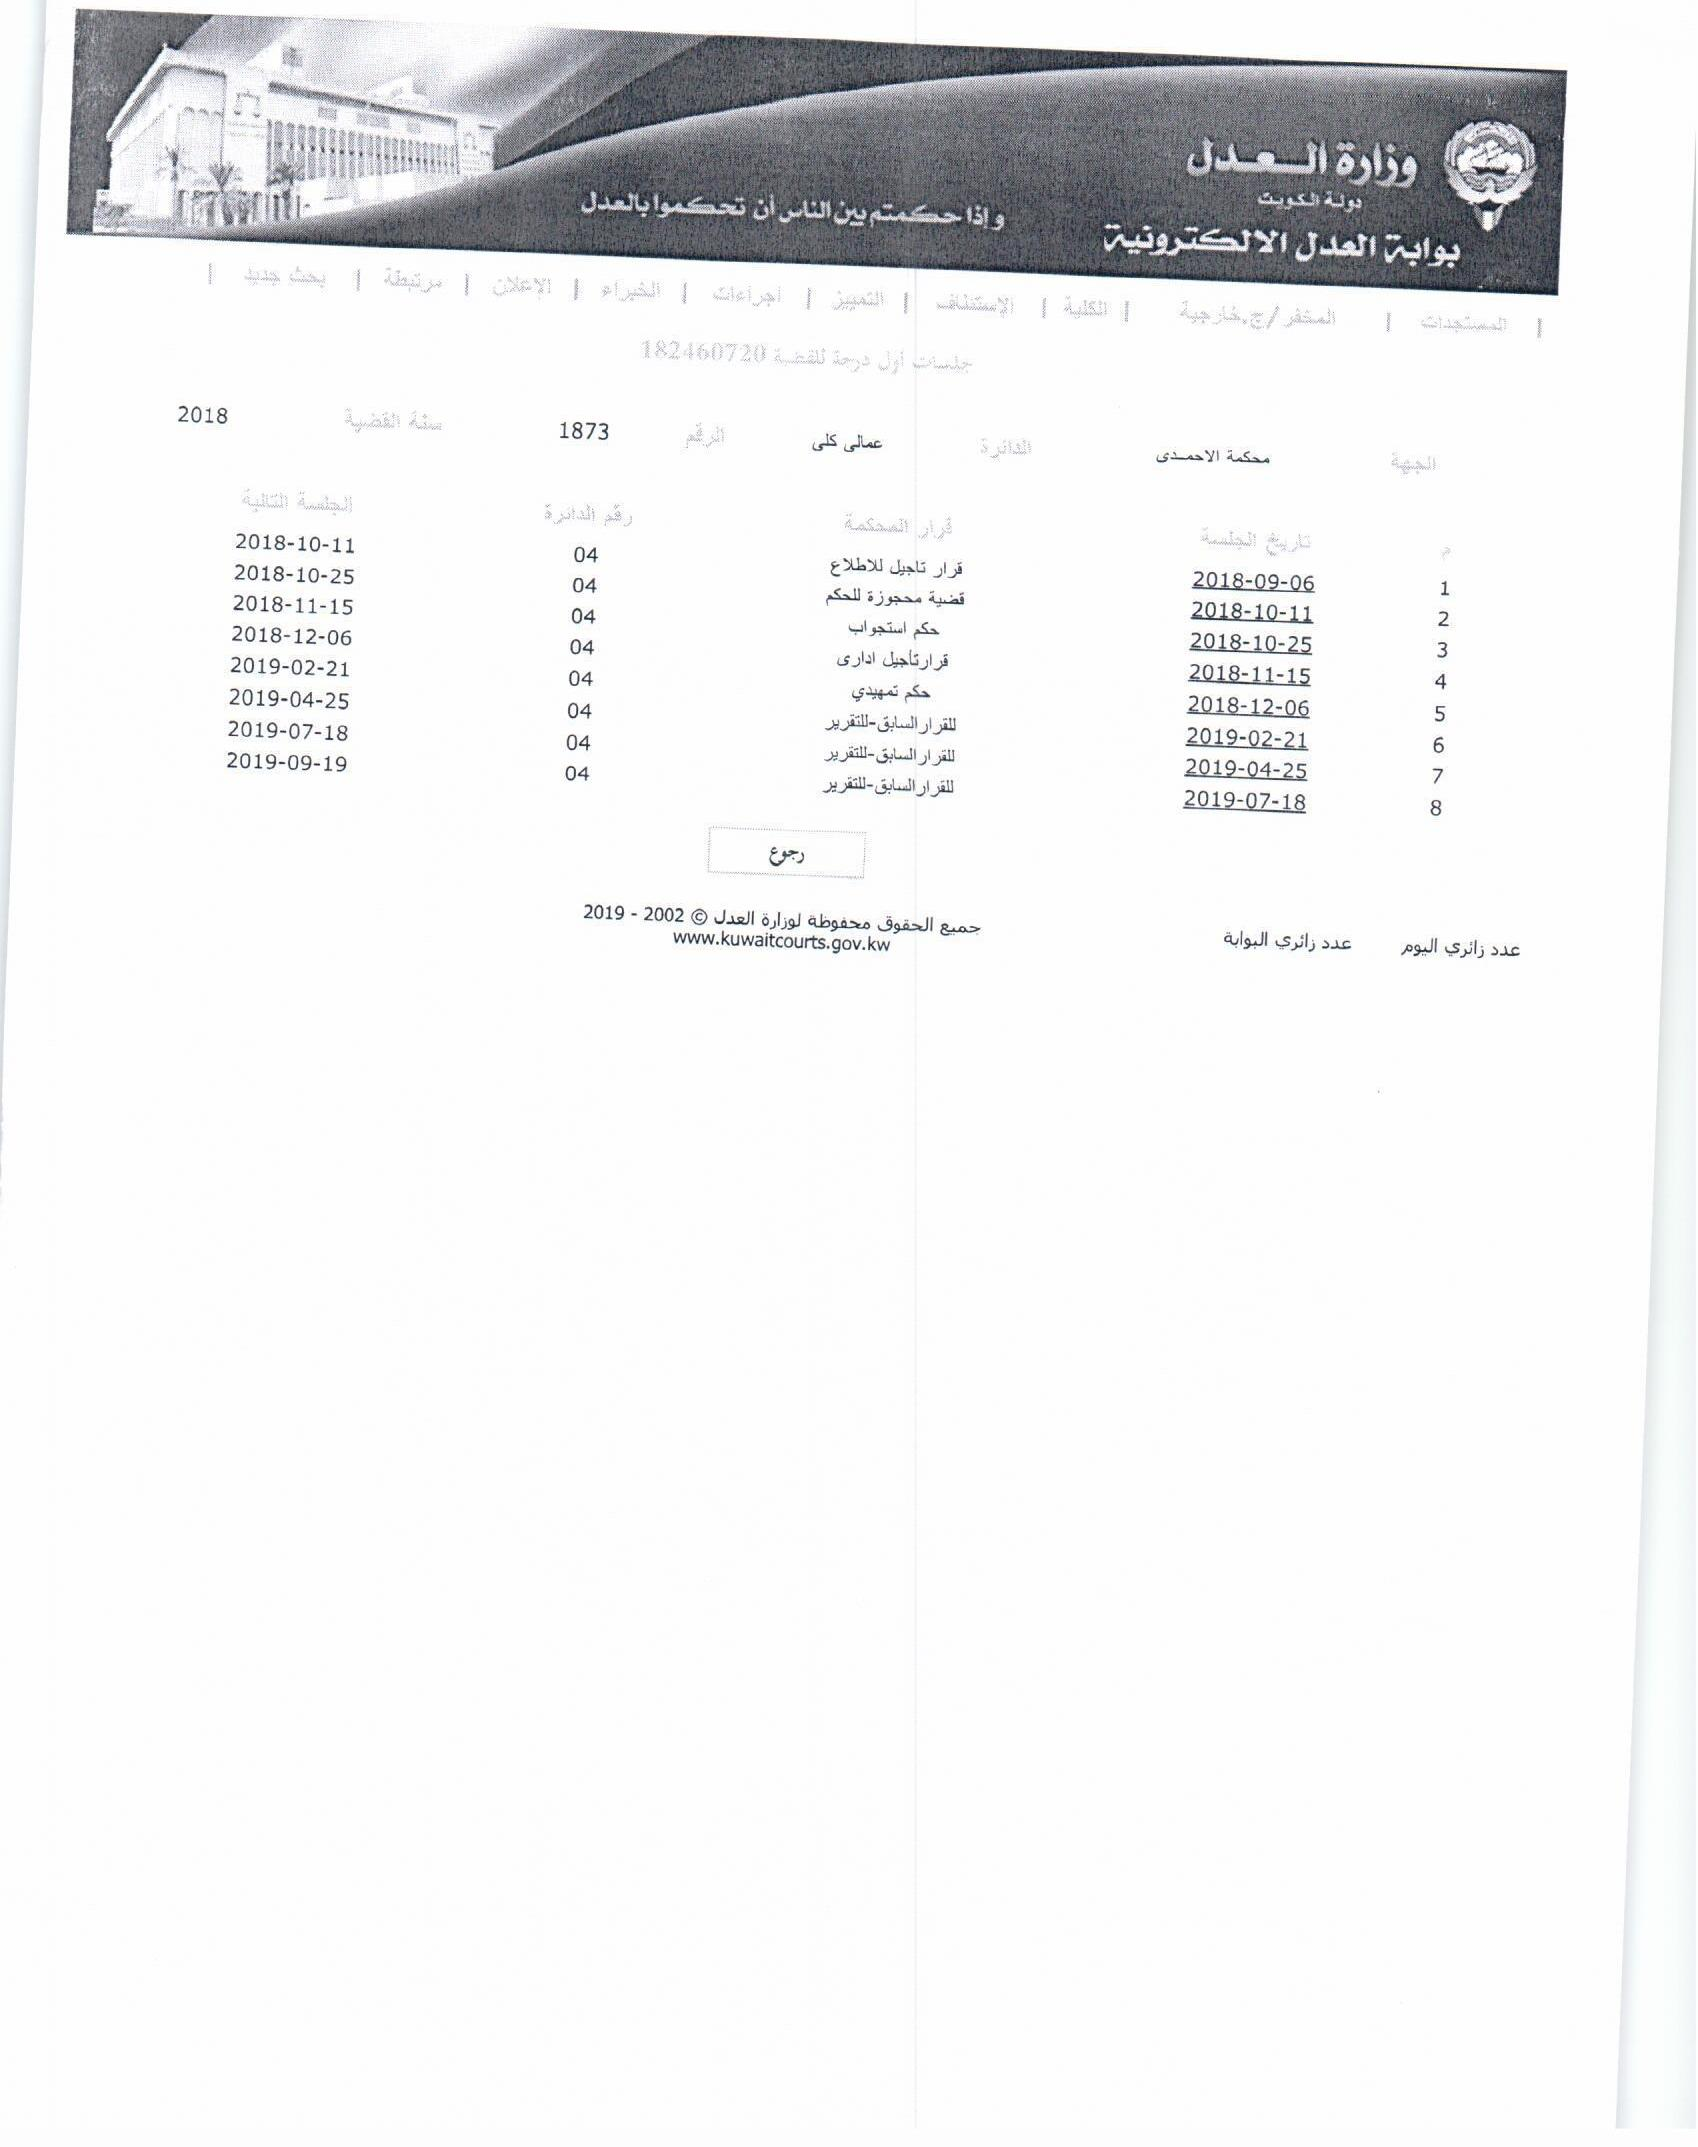
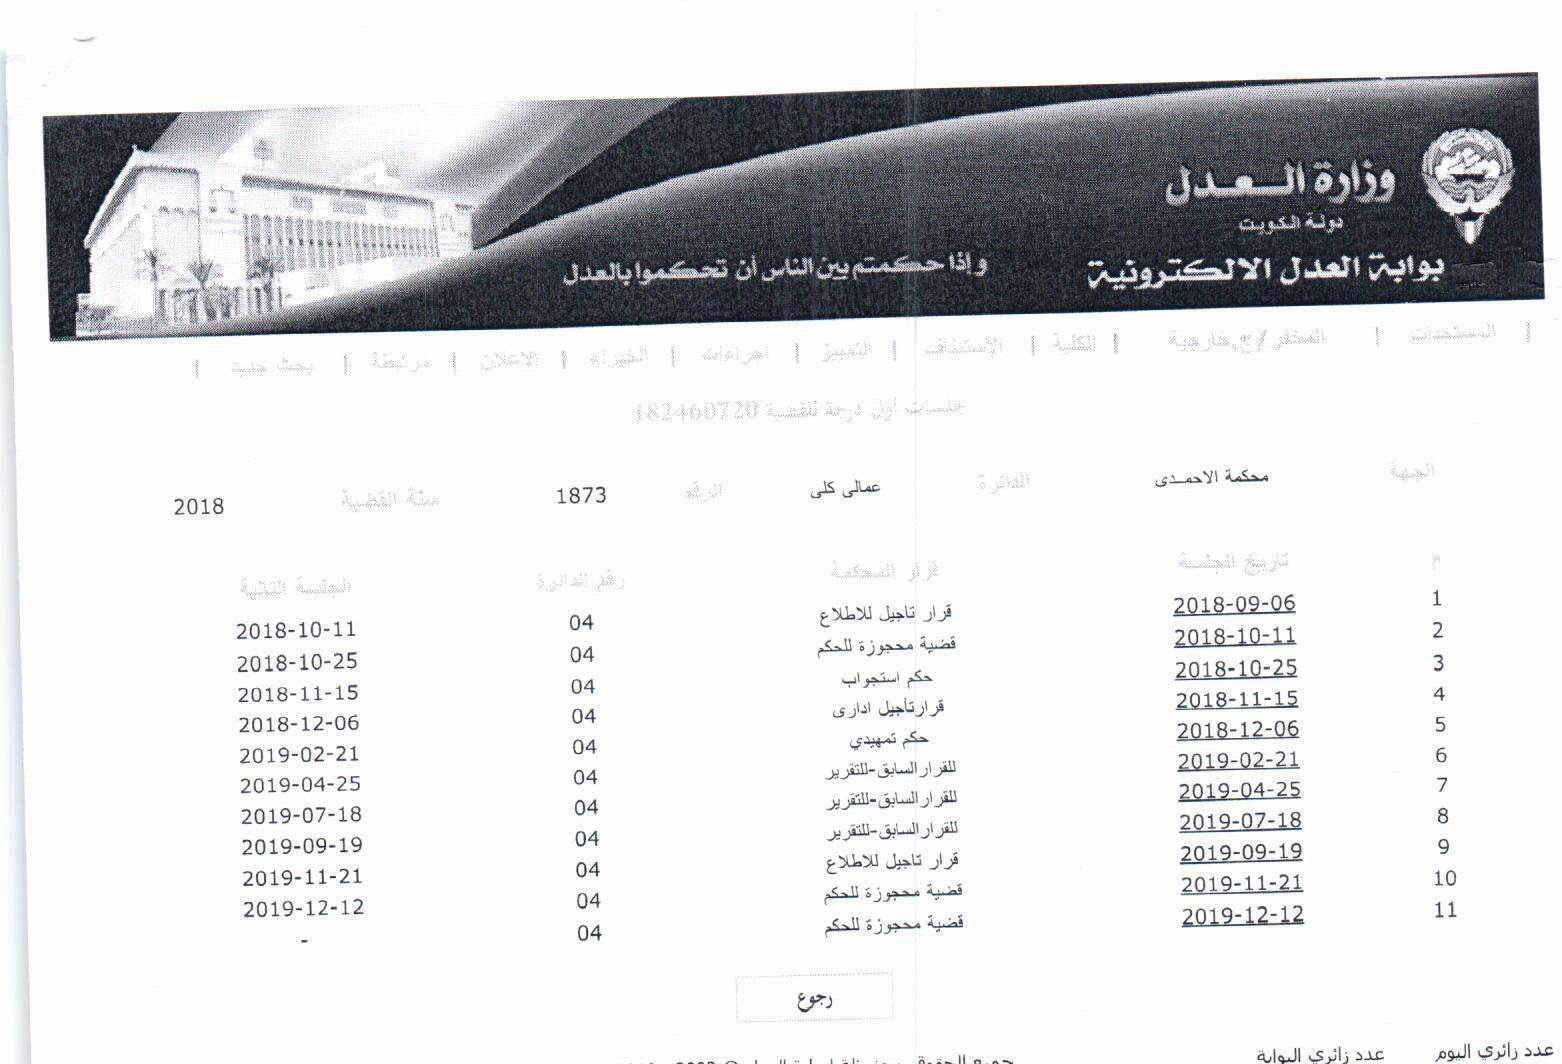
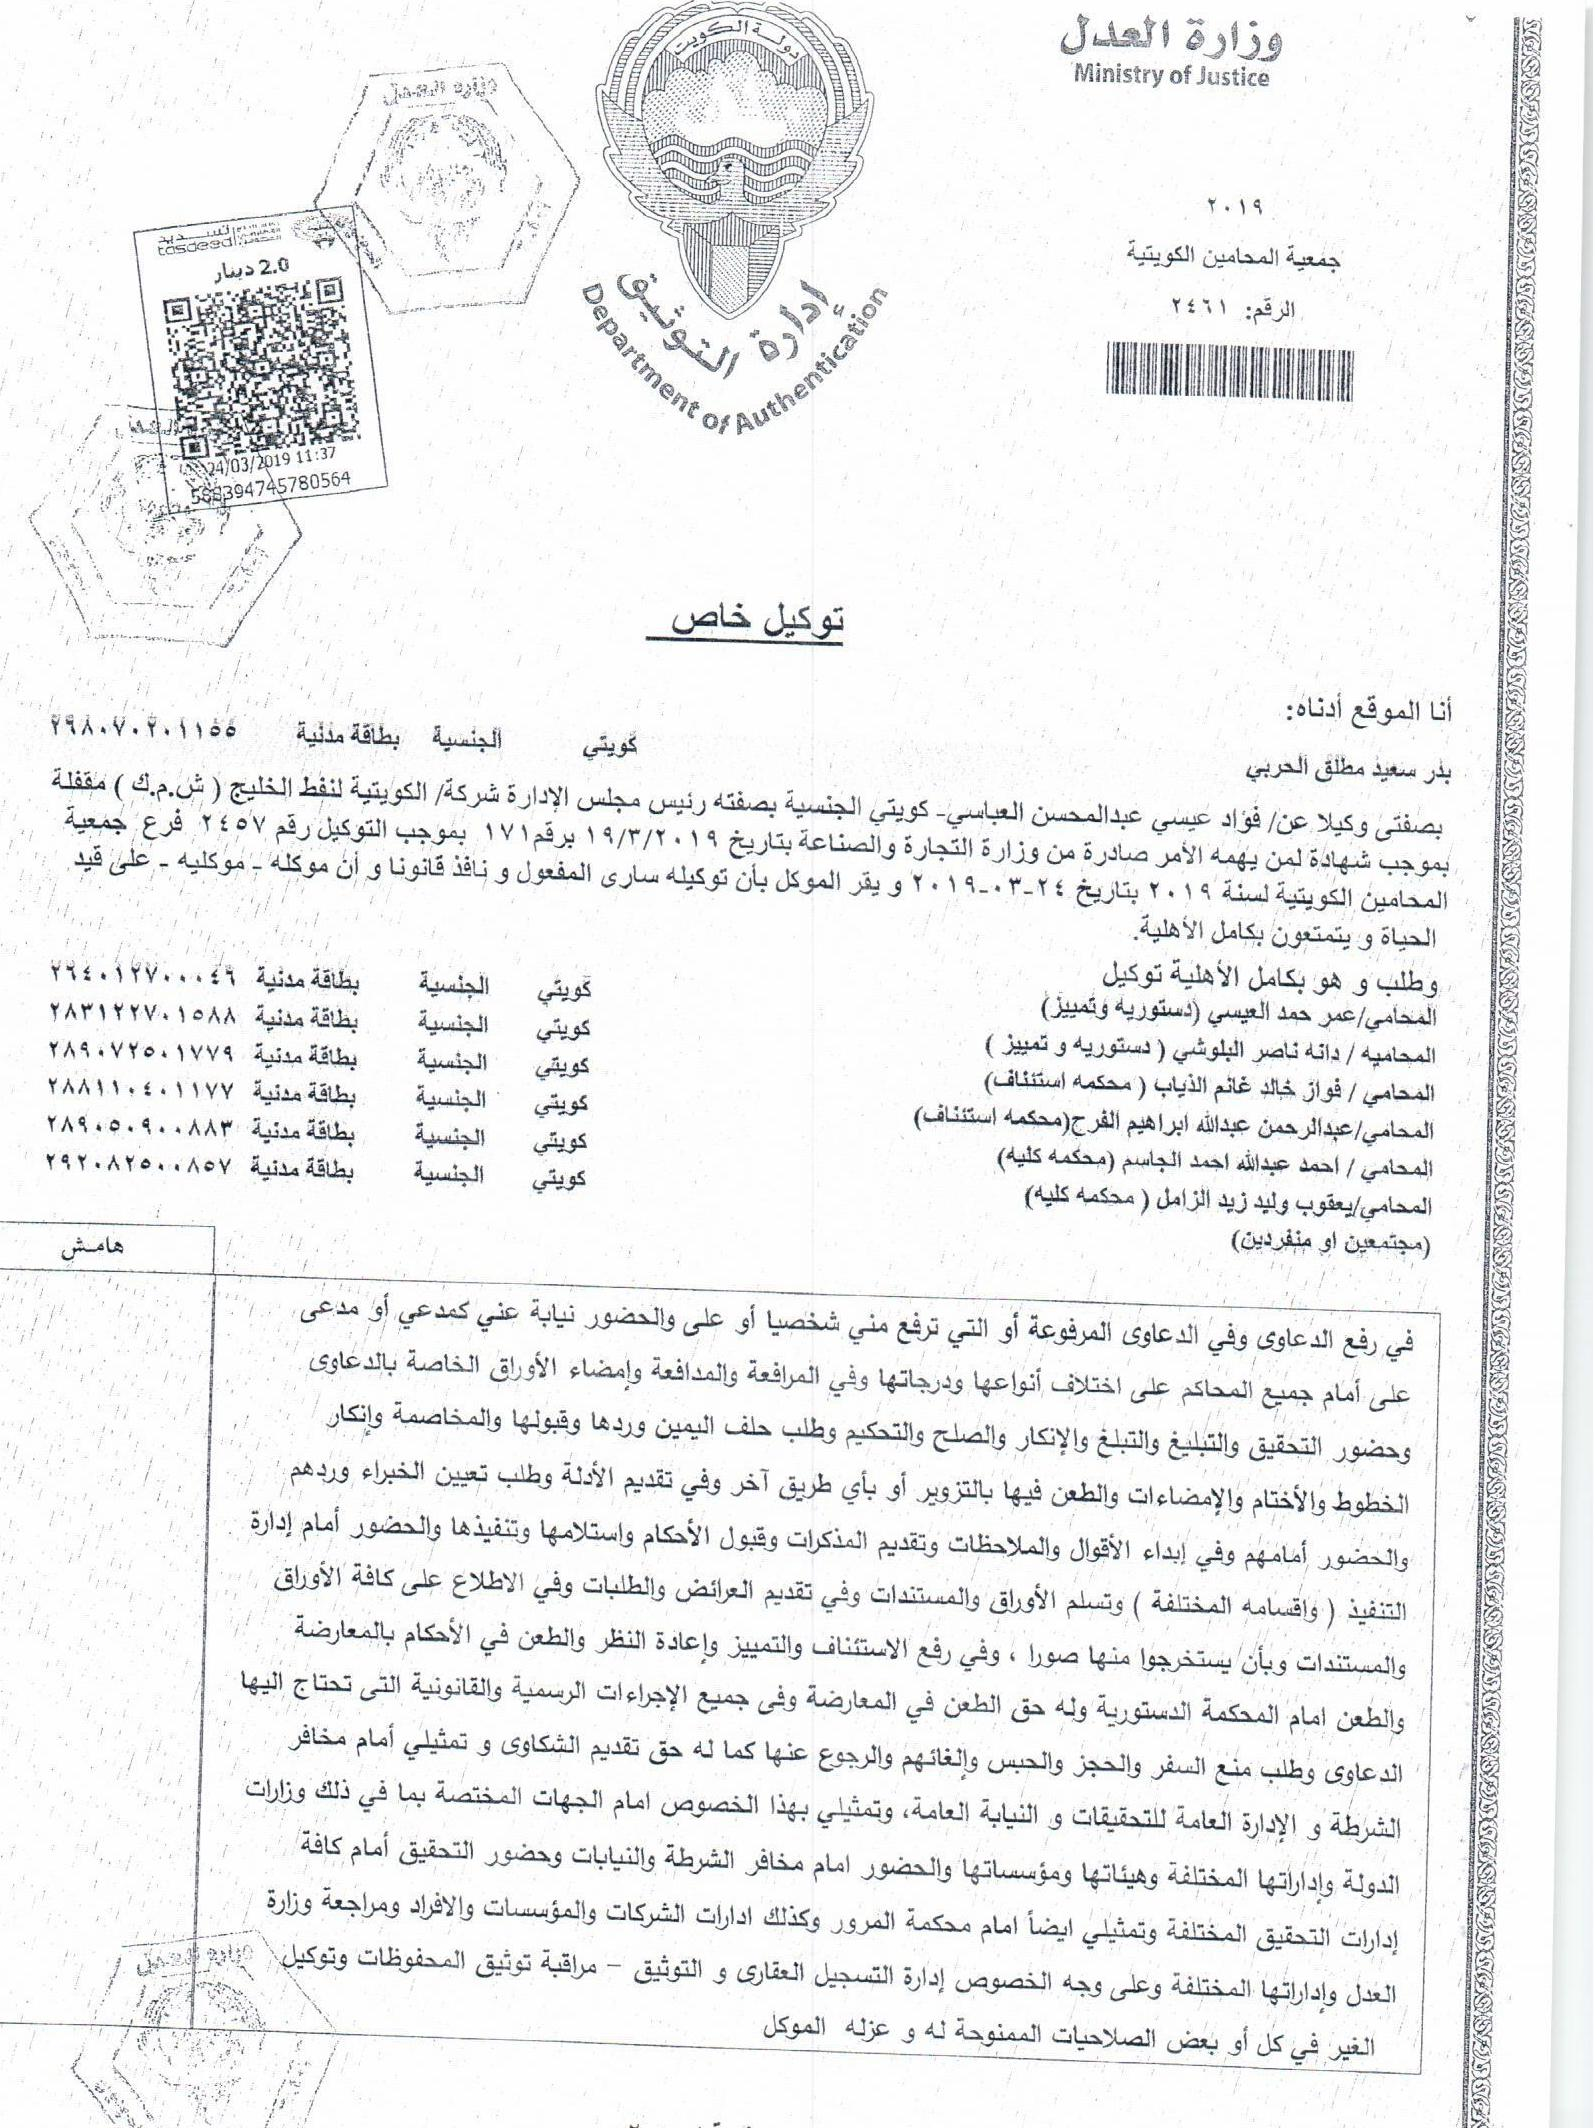
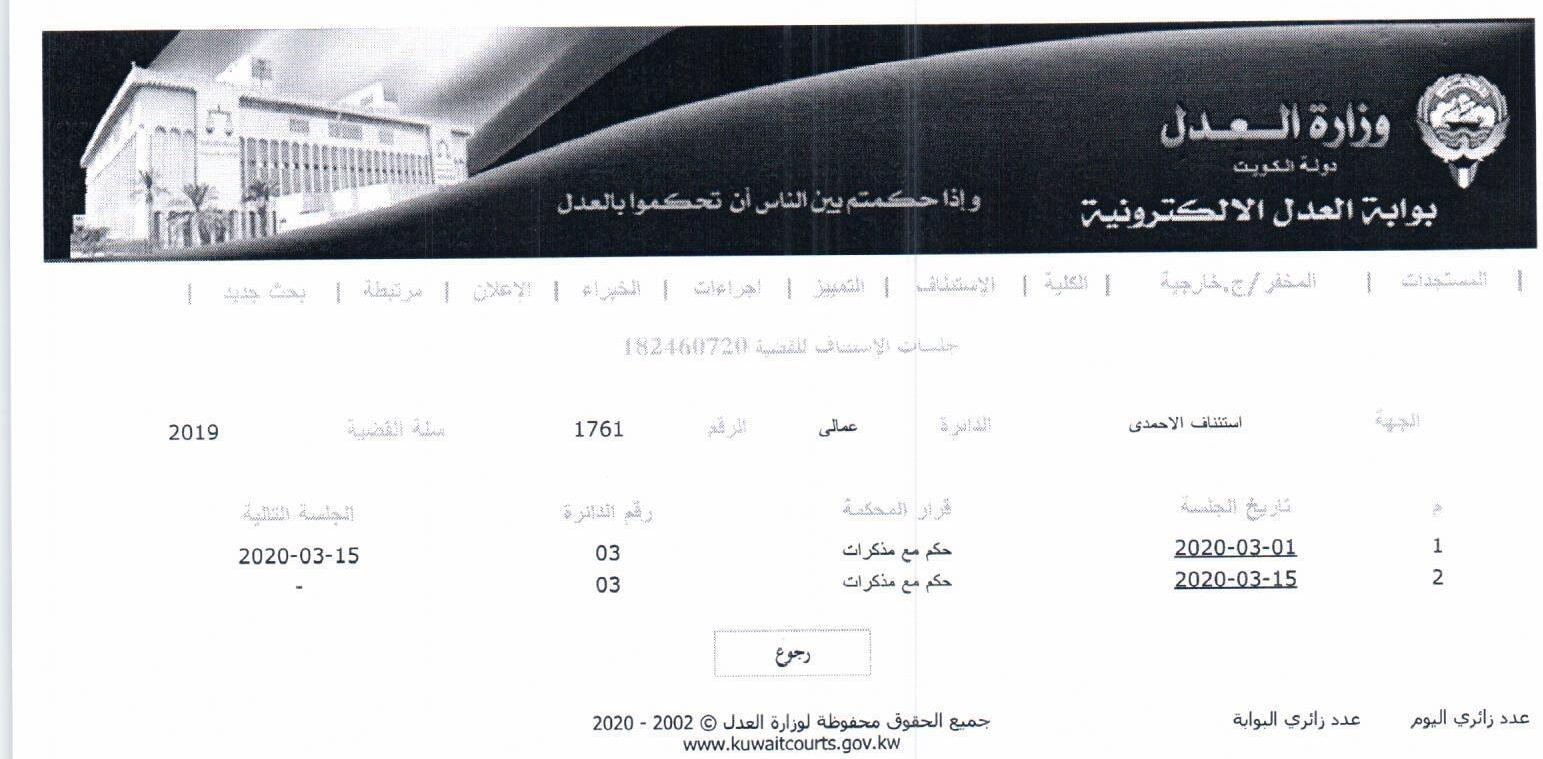
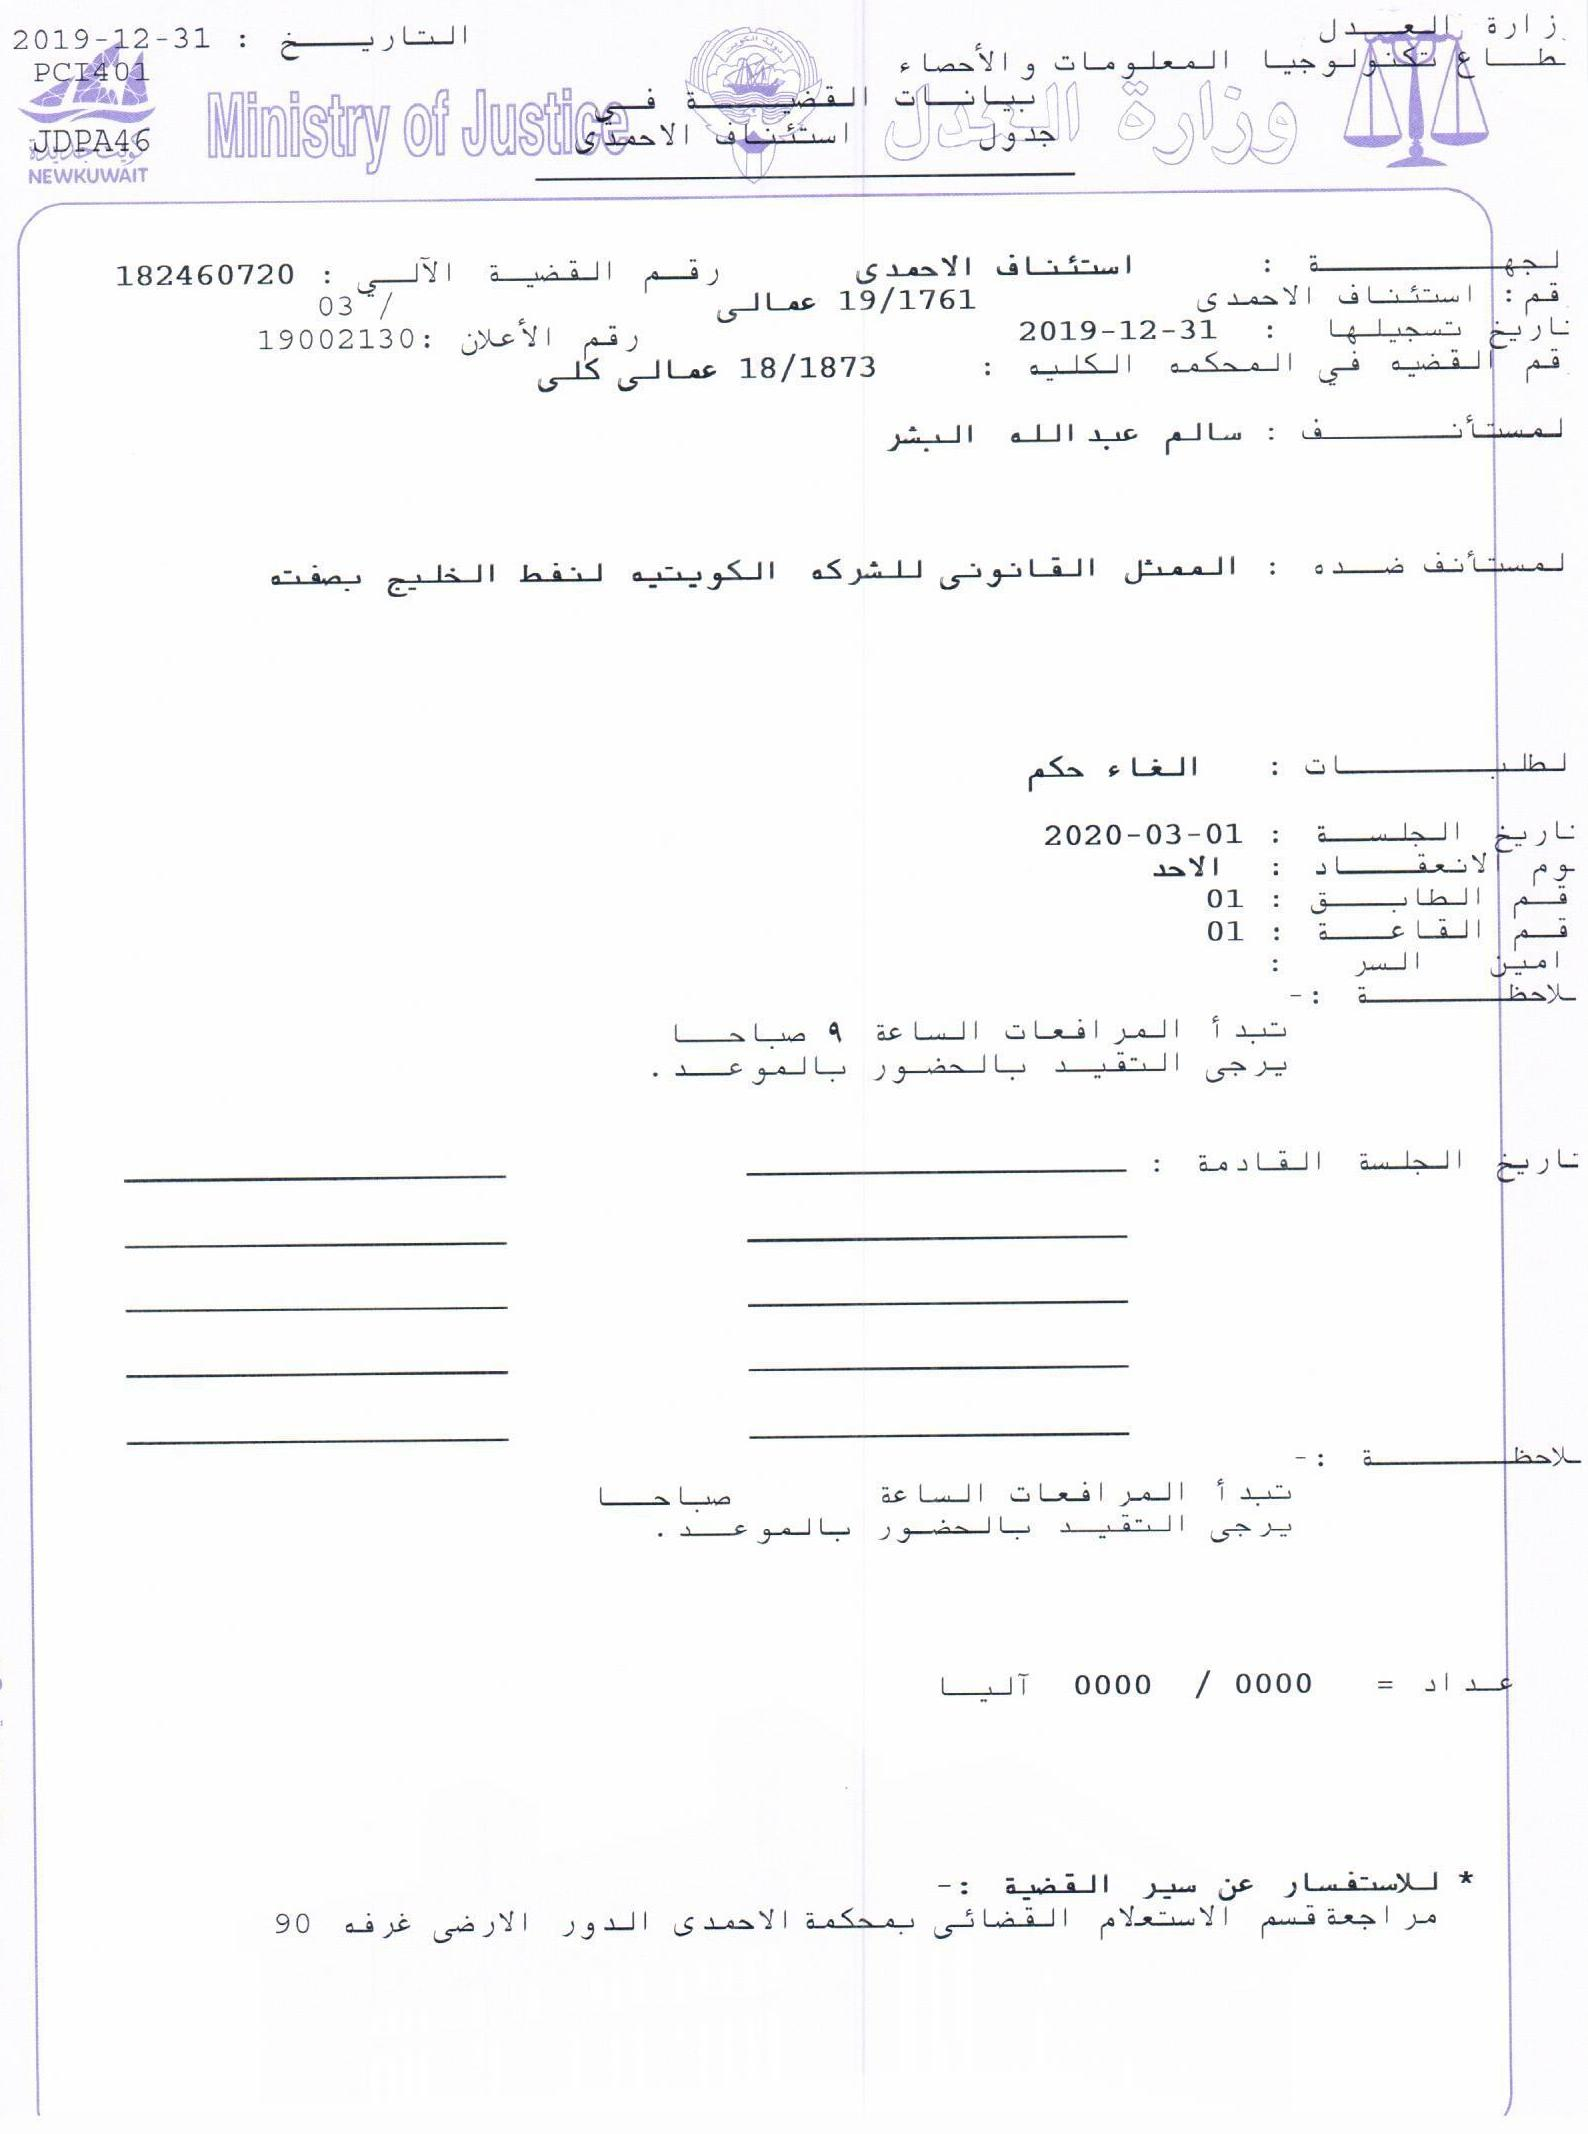

In [14]:
ocr_response.pages